# Integrando el problema

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# %load mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [3]:
# %load labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [4]:
# %load events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

In [5]:
# %load sample_weights.py
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]


def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [6]:
MTUM_PATH = '../datasets/mtum.csv'

In [7]:
# Función que permite convertir el formato de las fechas como string
# en un objeto de fecha.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [8]:
mtum = pd.read_csv(MTUM_PATH, parse_dates=['Date'], date_parser=string_to_date, index_col='Date')

# Aprendemos el side

In [9]:
# Computamos los eventos de cruce de media moviles (a optimizar!)
fast_window_num_days = 2
slow_window_num_days = 5
tEvents = getEwmEvents(mtum['Close'], fast_window_num_days, slow_window_num_days)
tEvents

# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, mtum['Close'], numDays=num_days)
print("Barreras verticales para los eventos cruce de medias:")
print(t1)

# Definimos las bandas de PT y SL.
ptSl = [0.015, 0.005]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=mtum['Close'], span0=50)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.01
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(mtum['Close'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
print("Eventos de triple frontera y retorno obtenido: ")
print(triple_barrier_events)

# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, mtum['Close'])
print("Labels para triple frontera: ")
print(labels)

# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
print(labels['bin'].value_counts())

# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=mtum.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(mtum['Close'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=mtum['Close'])
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]
print("Dataframe de concurrencia de eventos en ventanas de triple frontera: ")
print(out)
print("Average uniqueness: ")
print(averageUniqueness)


# Genero un data frame entre las concurrencias y los retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
print("Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad")
print(coEvents_std)
print(coEvents_std.loc[:, "numCoEvents"].value_counts())

Barreras verticales para los eventos cruce de medias:
Date
2013-05-29   2013-06-04
2013-06-18   2013-06-24
2013-06-19   2013-06-25
2013-07-02   2013-07-08
2013-08-13   2013-08-19
                ...    
2020-04-01   2020-04-07
2020-04-06   2020-04-13
2020-08-11   2020-08-17
2020-08-12   2020-08-18
2020-09-08   2020-09-14
Name: Date, Length: 155, dtype: datetime64[ns]
Eventos de triple frontera y retorno obtenido: 
                   t1      trgt  side
Date                                 
2013-07-02 2013-07-03  0.013001   1.0
2013-10-14 2013-10-15  0.011511   1.0
2014-01-24 2014-01-27  0.011497  -1.0
2014-02-10 2014-02-11  0.013199   1.0
2014-03-14 2014-03-17  0.011612  -1.0
...               ...       ...   ...
2020-04-01 2020-04-02  0.052734  -1.0
2020-04-06 2020-04-07  0.052271   1.0
2020-08-11 2020-08-12  0.018101  -1.0
2020-08-12 2020-08-13  0.017754   1.0
2020-09-08 2020-09-09  0.023948  -1.0

[86 rows x 3 columns]
Labels para triple frontera: 
                 ret  bin
Date     

2020-11-14 10:08:07.365330 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.
2020-11-14 10:08:07.590513 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.
2020-11-14 10:08:07.842149 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.
2020-11-14 10:08:07.929979 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes.


Dataframe de concurrencia de eventos en ventanas de triple frontera: 
              tW         w
2013-07-02  1.00  0.058518
2013-10-14  1.00  0.055172
2014-01-24  1.00  2.673837
2014-02-10  1.00  1.106704
2014-03-14  1.00  0.400521
...          ...       ...
2020-04-01  1.00  2.566782
2020-04-06  1.00  4.620832
2020-08-11  0.75  0.526596
2020-08-12  0.75  1.397481
2020-09-08  1.00  0.956847

[86 rows x 2 columns]
Average uniqueness: 
0.9651162790697675
Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad
            numCoEvents       std
Date                             
2013-04-18          0.0       NaN
2013-04-19          0.0       NaN
2013-04-22          0.0       NaN
2013-04-23          0.0  0.018053
2013-04-24          0.0  0.012640
...                 ...       ...
2020-09-09          1.0  0.023639
2020-09-10          0.0  0.023281
2020-09-11          0.0  0.023249
2020-09-14          0.0  0.023180
2020-09-15          0.0  0.023856

[1867 rows x 2 col

# Modelos de ML para determinar la probabilidad (tamaño) de la apuesta

In [10]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

# Preparamos la informacion para introducirla en un modelo de ML.
Xy = (pd.merge_asof(triple_barrier_events, labels[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
print(Xy)

X = Xy.copy()[['trgt', 'side']].values
y = Xy.copy().bin.values
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)

# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123,
                            oob_score=True)
rf.fit(X_train, y_train)

print("Out of bag accuracy: ")
print(rf.oob_score_)

# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print(classification_report(y_test, y_pred_rf))

                   t1      trgt  side  bin
Date                                      
2013-07-02 2013-07-03  0.013001   1.0  1.0
2013-10-14 2013-10-15  0.011511   1.0  0.0
2014-01-24 2014-01-27  0.011497  -1.0  1.0
2014-02-10 2014-02-11  0.013199   1.0  1.0
2014-03-14 2014-03-17  0.011612  -1.0  0.0
...               ...       ...   ...  ...
2020-04-01 2020-04-02  0.052734  -1.0  0.0
2020-04-06 2020-04-07  0.052271   1.0  0.0
2020-08-11 2020-08-12  0.018101  -1.0  0.0
2020-08-12 2020-08-13  0.017754   1.0  1.0
2020-09-08 2020-09-09  0.023948  -1.0  0.0

[86 rows x 4 columns]
Out of bag accuracy: 
0.4
              precision    recall  f1-score   support

         0.0       0.44      0.82      0.57        28
         1.0       0.44      0.12      0.19        33

    accuracy                           0.44        61
   macro avg       0.44      0.47      0.38        61
weighted avg       0.44      0.44      0.37        61



In [11]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123, oob_score=True)
bc.fit(X_train, y_train)

print("Out of bag accuracy: ")
print(bc.oob_score_)

# Predecimos con el test set y contrastamos.
y_pred_bc_prob = bc.predict_proba(X_test)[:, 1]
y_pred_bc = bc.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_prob)
print(classification_report(y_test, y_pred_bc))

Out of bag accuracy: 
0.36
              precision    recall  f1-score   support

         0.0       0.46      0.86      0.60        28
         1.0       0.56      0.15      0.24        33

    accuracy                           0.48        61
   macro avg       0.51      0.50      0.42        61
weighted avg       0.51      0.48      0.40        61



In [12]:
# Usamos bagging ahora con el averageUniqueness
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = averageUniqueness     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc2 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123, oob_score=True)
bc2.fit(X_train, y_train)

print("Out of bag accuracy: ")
print(bc2.oob_score_)

# Predecimos con el test set y contrastamos.
y_pred_bc2_prob = bc2.predict_proba(X_test)[:, 1]
y_pred_bc2 = bc2.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc2, tpr_bc2, _ = roc_curve(y_test, y_pred_bc2_prob)
print(classification_report(y_test, y_pred_bc2))

Out of bag accuracy: 
0.36
              precision    recall  f1-score   support

         0.0       0.48      0.82      0.61        28
         1.0       0.62      0.24      0.35        33

    accuracy                           0.51        61
   macro avg       0.55      0.53      0.48        61
weighted avg       0.55      0.51      0.47        61



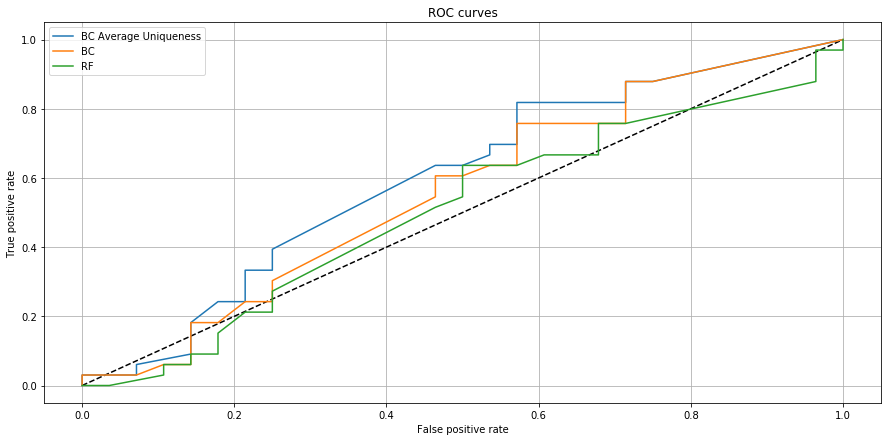

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc2, tpr_bc2, label='BC Average Uniqueness')
plt.plot(fpr_bc, tpr_bc, label='BC')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.grid()
plt.show()